In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

from torch.utils.data import DataLoader, TensorDataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# LSTM

In [11]:
df = pd.read_csv(fr'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv')
df.head()

,Date,Open,Close,Change,sentiment,sentiment_score
0,2025-01-10,3761.549,3736.886,-0.66,0,0.700804
1,2024-12-19,3780.106,3708.531,-1.93,0,0.950467
2,2024-12-18,3774.744,3781.551,0.18,1,0.460880
3,2024-12-16,3748.220,3765.163,0.45,1,0.771217
4,2024-12-12,3744.519,3748.267,0.10,1,0.927686


In [12]:

# Convert 'Date' column to datetime objects if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Select features and target variable
features = ['Open', 'sentiment_score'] # Add more relevant features
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [13]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 # Adjust the sequence length as needed
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with one neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32) #Adjust epochs and batch size


# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate R-squared (R2)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Epoch 1/50
11/11 [==============================] - 3s 7ms/step - loss: 0.0811
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0234
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0175
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 11/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 12/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 13/50
11/11 [==============================

3/3 [==============================] - 1s 3ms/step


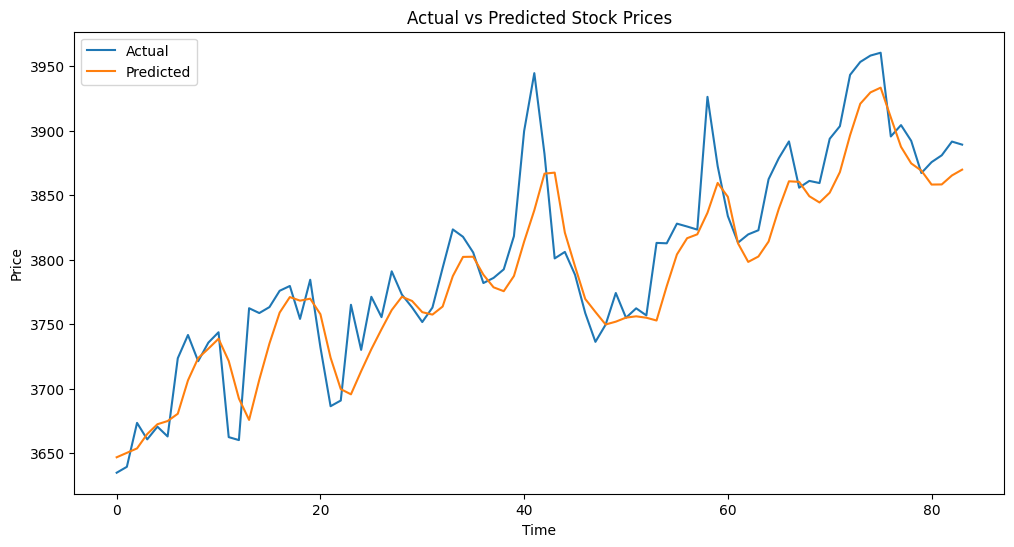

In [15]:
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# CNN


In [16]:
# Assuming 'df' is your DataFrame
# Select relevant columns and convert the 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
data = df[['Date', 'Close']]
data = data.set_index('Date')

# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the data for the CNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 # Example sequence length
X, y = create_sequences(data['Close'].values, seq_length)

# Reshape data for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)


# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model 
model.fit(X, y, epochs=50, batch_size=32, verbose=1) # Adjust epochs and batch size as needed


Epoch 1/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0719
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 3/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 5/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 9/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 10/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 11/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 12/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 13/50
14/14 [==============================

14/14 [==============================] - 0s 1000us/step


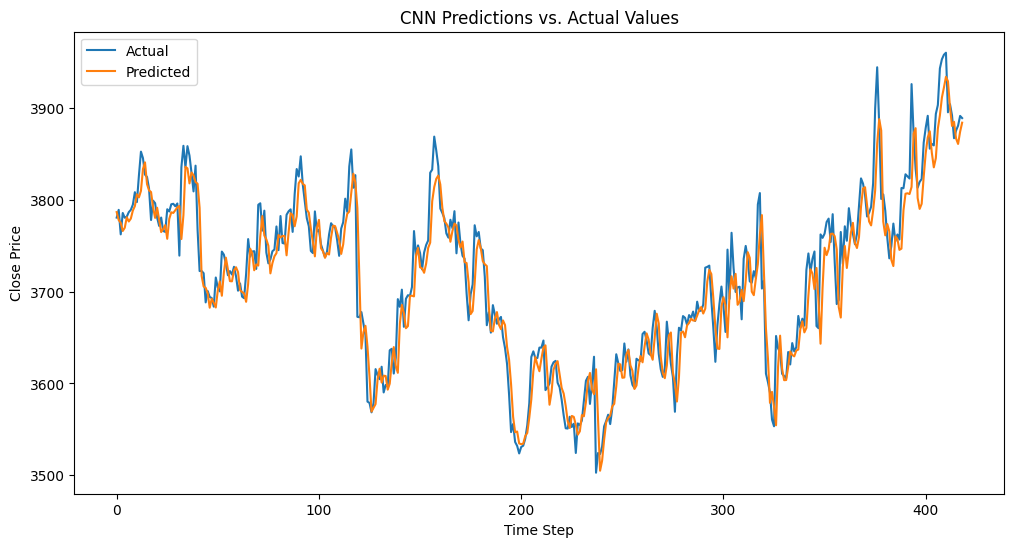

In [17]:
predictions = model.predict(X)

# Inverse transform the predictions and actual values to get original scale
predictions = scaler.inverse_transform(predictions)
y_original = scaler.inverse_transform(y.reshape(-1, 1))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('CNN Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()